#**TRAINING A TRANSFORMER WITH PYTORCH**

**A Bit of the History**


*   The Transformer architecture was **introduced in June 2017**.
*   Vaswani, Ashish, et al. "**Attention is all you need**." Advances in neural information processing systems 30 (2017).
*   The **focus** of the original research **was on language translation tasks.**
*   Several **infulential models** that came after Transformers:




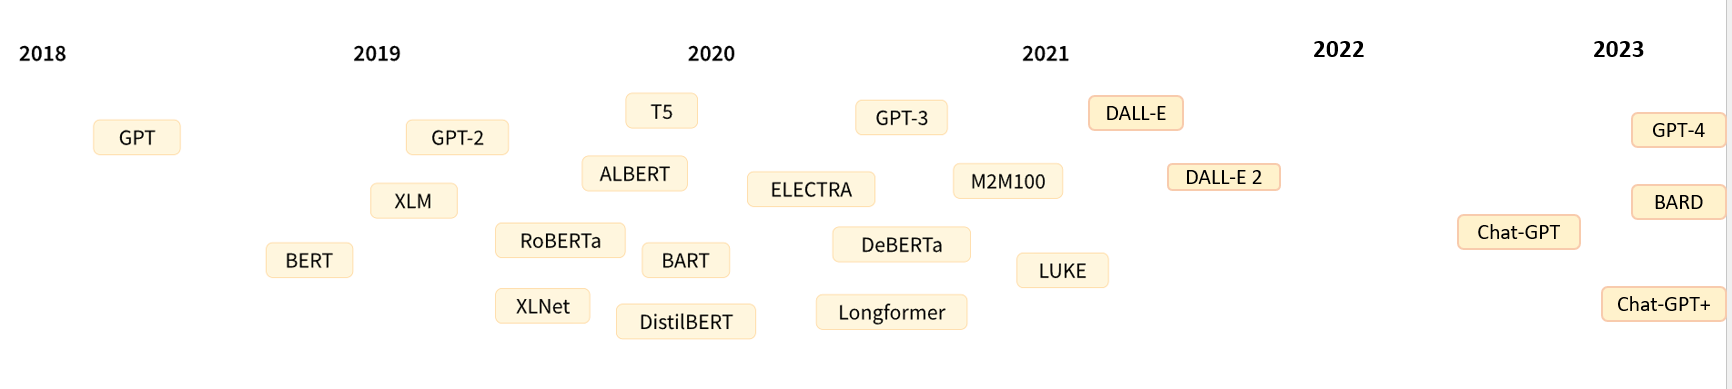

**Brief Introduction**


*   A Transformer is a **sequence-to-sequence encoder-decoder model** similar to the RNN model.
*   Unlike RNN, **Transformer is parallelizable**.
*   Transformers make no assumptions about the **temporal/spatial relationships** across the data, it **is learnt**.
*   The temporal relation between the words in a sentence/ sequence is encoded by **self attention layers**.



As explained in the [Google AI Blog post](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html):

> Neural networks for machine translation typically contain an encoder reading the input sentence and generating a representation of it. A decoder then generates the output sentence word by word while consulting the representation generated by the encoder. The Transformer starts by generating initial representations, or embeddings, for each input word. Then, using self-attention, it aggregates information from all of the other words, generating a new representation per word informed by the entire context, represented by the filled balls. This step is then repeated multiple times in parallel for all words, successively generating new representations.



---
---

**Goal of the tutorial**

To build our Transformer model, we’ll follow these steps:

1. **SETUP:** Import necessary libraries and modules.
2. **DEFINE THE BASIC BUILDING BLOCK**: Positional Encoding, Multi-Head Attention, Position-wise Feed-Forward Networks.
3. **BUILDING THE LAYERS:** Build the Encoder and Decoder layers.
4. **Combine Encoder and Decoder layers** to create the complete Transformer model.
5. **Prepare sample data**.
6. **Train the model**.
7. **Inference and Visualization**


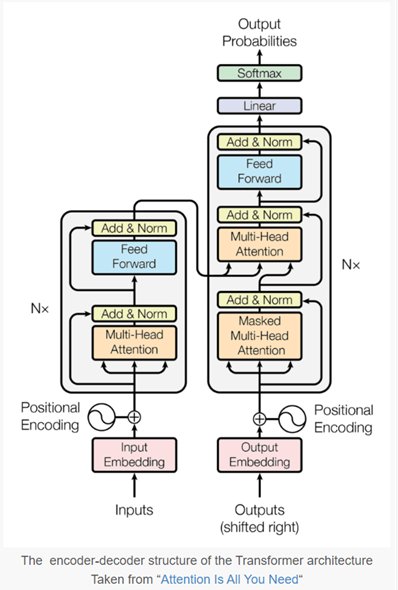

QUE: What task are we implementing ?

Ans: Machine Translation Task (English to German)

## 1. SETUP

In [ ]:
import torch                      # A Tensor library like NumPy, with strong GPU support.
import torch.nn as nn             # A neural networks library deeply integrated with autograd designed for maximum flexibility.
import torch.optim as optim       # A package implementing various optimization algorithms.
import torch.utils.data as data     # Basically used for loading and iterating over a dataset. (For more info: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html )
import math
import copy                       # Assignment statements do not copy objects, they create bindings between a target and an object.
                                  # When we use the = operator, It only creates a new variable that shares the reference of the original object.
                                  # In order to create “real copies” or “clones” of these objects, we use the copy module in Python.

#2.1 BASIC BUILDING BLOCK : Positional Encoding

**QUE:** What are Positional Encodings ?

**Ans:** Position information of each token in the input sequence.

---

**QUE:** Why are we using it ?

**Ans:** Because Attention is **Permutation Invariant** means changing the order of the words in your sentence is not going to affect the actual output.

---

**QUE:** How to implement it ?

**Ans:** The original paper uses the following formula for calculating the positional encoding:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

It uses sine and cosine functions of different frequencies to generate the positional encoding.

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):       # d_model = dimensions of the output generated by the model at each layer (This is to make info flow easier for the residual connections)
        super(PositionalEncoding, self).__init__()     # max_seq_length = The maximum length of the sentences. All sentences less than this 'maximum length' are zero padded.

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)                # unsqueeze(1) adds an extra dimension at index 1. This changes the shape of the tensor from [max_len] to [max_len, 1].
                                                                                                  # The extra dimension is added to facilitate the broadcasting mechanism when computing the sine and cosine functions for the positional encodings.
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))   # CAN YOU TELL WHY THE STEP-SIZE IS 2 ???
                                                                                                     # The negative sign is crucial because it creates a decaying factor. Without it, the values would grow exponentially rather than decay, which would ...
                                                                                                     # ... distort the positional encoding and negatively impact the model's ability to learn and generalize from positional information.

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):                                   # the forward() method in a class derived from nn.Module defines the computation that the model will perform when it processes input data...
        return x + self.pe[:, :x.size(1)]                   # ...It specifies how input data flows through the model's layers and operations to produce the output.

#2.2 BASIC BUILDING BLOCK : Multi-head Attention
The Multi-Head Attention mechanism computes the attention between each pair of positions in a sequence. It consists of multiple “attention heads” that capture different aspects of the input sequence.

<table>
<tr>
  <th>The RNN+Attention model</a></th>
  <th>A 1-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=411 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-words.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):                                         # input is : dimension of the model and number of attention heads.
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"   # Just a Check !

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)                                      # WHAT ARE WE DOING HERE ? Are we creating a layer OR a matrix ??
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)    # WHY ARE WE USING (-2, -1) INSIDE transpose()  ?? Is it necessary ?
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)                             # Attention probabilities are computed.
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):                                                         # Because we are using MHA (Multi-Head Attention)
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

#2.3 BASIC BUILDING BLOCK : Position-wise Feed-Forward Networks

The PositionWiseFeedForward class extends PyTorch’s nn.Module and implements a position-wise feed-forward network. The class initializes with two linear transformation layers and a ReLU activation function. The forward method applies these transformations and activation function sequentially to compute the output. This process enables the model to consider the position of input elements while making predictions.

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

#Encoder Layer

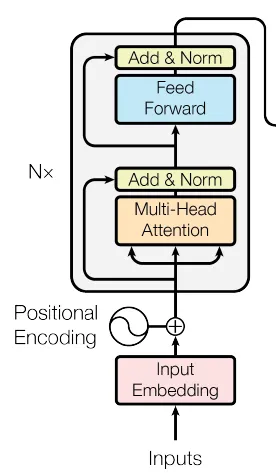

#3. **BUILDING THE LAYERS:**
Encoder layer consists of a Multi-Head Attention layer, a Position-wise Feed-Forward layer, and two Layer Normalization layers.

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

#Decoder Layer

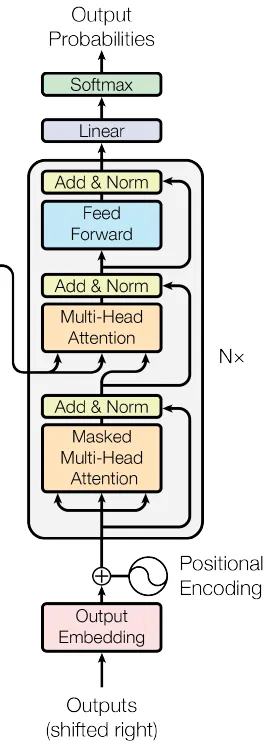

# 3. **BUILDING THE LAYERS:**
A Decoder layer consists of two Multi-Head Attention layers, a Position-wise Feed-Forward layer, and three Layer Normalization layers.

The forward method computes the decoder layer output by performing the following steps:

1. Calculate the masked self-attention output and add it to the input tensor, followed by dropout and layer normalization.

2. Compute the cross-attention output between the decoder and encoder outputs, and add it to the normalized masked self-attention output, followed by dropout and layer normalization.

3. Calculate the position-wise feed-forward output and combine it with the normalized cross-attention output, followed by dropout and layer normalization.

4. Return the processed tensor.

These operations enable the decoder to generate target sequences based on the input and the encoder output.

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

The forward method computes the Transformer model’s output through the following steps:

1. Generate source and target masks using the generate_mask method.

2. Compute source and target embeddings, and apply positional encoding and dropout.

3. Process the source sequence through encoder layers, updating the enc_output tensor.

4. Process the target sequence through decoder layers, using enc_output and masks, and updating the dec_output tensor.

5. Apply the linear projection layer to the decoder output, obtaining output logits.

These steps enable the Transformer model to process input sequences and generate output sequences based on the combined functionality of its components.



In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()        # nopeak_mask is used to create a mask for the self-attention mechanism in transformer models, particularly in the decoder during training.
                                                                                                        # This mask ensures that the prediction for a particular position can only depend on the known outputs at previous positions, not future positions. This is crucial for autoregressive tasks like language modeling.
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)                                  # Encoder masking is optional.

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

#5. PREPARING THE SAMPLE DATA

In this example, we will create a toy dataset for demonstration purposes. In practice, you would use a larger dataset, preprocess the text, and create vocabulary mappings for source and target languages.

In [ ]:
src_vocab_size = 5000
tgt_vocab_size = 5000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048 #dimension of feed-forward layer
max_seq_length = 100
dropout = 0.1

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# Generate random sample data
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

#6. TRAINING THE MODEL

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

for epoch in range(100):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1])
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

Epoch: 1, Loss: 8.6756010055542
Epoch: 2, Loss: 8.545374870300293
Epoch: 3, Loss: 8.476218223571777
Epoch: 4, Loss: 8.416267395019531
Epoch: 5, Loss: 8.35931396484375
Epoch: 6, Loss: 8.282073974609375
Epoch: 7, Loss: 8.199085235595703
Epoch: 8, Loss: 8.121031761169434
Epoch: 9, Loss: 8.040597915649414
Epoch: 10, Loss: 7.953232288360596
Epoch: 11, Loss: 7.86962890625
Epoch: 12, Loss: 7.791081428527832
Epoch: 13, Loss: 7.70359468460083
Epoch: 14, Loss: 7.621032238006592
Epoch: 15, Loss: 7.540018081665039
Epoch: 16, Loss: 7.458738803863525
Epoch: 17, Loss: 7.370782852172852
Epoch: 18, Loss: 7.289713382720947
Epoch: 19, Loss: 7.214544773101807
Epoch: 20, Loss: 7.139204978942871
Epoch: 21, Loss: 7.050459861755371
Epoch: 22, Loss: 6.975365161895752
Epoch: 23, Loss: 6.898815631866455
Epoch: 24, Loss: 6.826595306396484
Epoch: 25, Loss: 6.753725528717041
Epoch: 26, Loss: 6.672556400299072
Epoch: 27, Loss: 6.599162578582764
Epoch: 28, Loss: 6.528015613555908
Epoch: 29, Loss: 6.457740306854248
Ep

# 7. INFERENCE and VISUALIZATION

The following steps are used for inference:

* Encode the input sequence using a Embedder. This is the encoder input.
* The decoder input is initialized to the `[START]` token.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Concatenate the predicted token to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next token based on the previous tokens it predicted.



## Visualization of learned attention weights generated from a Transfomer trained to translate Portugese in English:

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" alt="Attention heatmap">

<table>
<td>
<tr>
  <th>Cross Attention: each query sees the whole context.</th>
  <th colspan=1>Self attention</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new.png"/>
  </td>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new-full.png"/>
  </td>
</tr>
</table>